In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Accessing the Electricity Demand Dataset

This notebook assumes that you have downloaded the [electricity-demand](https://huggingface.co/datasets/EDS-lab/electricity-demand/tree/main/data) dataset from HuggingFace. To execute this notebook create a folder `data/electricity-demand/` and download the 3 files into it.


The `01. Univariate.ipynb` notebook explain the basics of the dataset and how to access it. If you have not read it, please do so before continuing.


In [2]:
from enfobench.datasets import ElectricityDemandDataset

ds = ElectricityDemandDataset("../data/electricity-demand")

In [3]:
unique_ids = ds.metadata_subset.list_unique_ids()
unique_id = unique_ids[0]

In [4]:
target, weather, metadata = ds.get_data_by_unique_id(unique_id)

In [5]:
target.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25029 entries, 2012-09-24 12:00:00 to 2014-02-28 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       25028 non-null  float64
dtypes: float64(1)
memory usage: 391.1 KB


In [6]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12853 entries, 2012-09-17 12:00:00 to 2014-03-07 00:00:00
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   temperature_2m              12853 non-null  float32
 1   relative_humidity_2m        12853 non-null  float32
 2   dew_point_2m                12853 non-null  float32
 3   apparent_temperature        12853 non-null  float32
 4   precipitation               12853 non-null  float32
 5   rain                        12853 non-null  float32
 6   snowfall                    12853 non-null  float32
 7   snow_depth                  12853 non-null  float32
 8   weather_code                12853 non-null  float32
 9   pressure_msl                12853 non-null  float32
 10  surface_pressure            12853 non-null  float32
 11  cloud_cover                 12853 non-null  float32
 12  cloud_cover_low             12853 non-null  float32
 

The `weather` contains all the external weather parameters for the whole duration of the dataset. At this point these features could be used either as past covariates or as future covariates. To use them as past covariates you don't have to do anything. 

However, future covariates are used differently in enfobench. These simulate external forecast data that is available at regular intervals. At each cutoff date, the last available forecast data is used to make predictions for the future. You can transform the `past_covariates` into `future_covariates` by using the `create_perfect_forecasts_from_covariates` function. This as the name suggest creates perfect forecasts from the past covariates that you can use for model evaluation. 

In the real benchmarking process, the future covariates are not perfect, but real forecasts from external sources.

In [7]:
from enfobench.datasets.utils import create_perfect_forecasts_from_covariates

Let's create a perfect forecast dataset from the past covariates with a horizon of 4 days and 24 hours between forecasts.

In [8]:
perfect_weather_forecasts = create_perfect_forecasts_from_covariates(
    weather[['temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'wind_direction_10m', 'cloud_cover']],
    start=pd.Timestamp("2013-01-01T00:00:00"),
    horizon=pd.Timedelta("4 days"),
    step=pd.Timedelta("24 hour"),
)

In [9]:
perfect_weather_forecasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41419 entries, 0 to 41418
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   cutoff_date           41419 non-null  datetime64[ns]
 1   timestamp             41419 non-null  datetime64[us]
 2   temperature_2m        41419 non-null  float32       
 3   relative_humidity_2m  41419 non-null  float32       
 4   wind_speed_10m        41419 non-null  float32       
 5   wind_direction_10m    41419 non-null  float32       
 6   cloud_cover           41419 non-null  float32       
dtypes: datetime64[ns](1), datetime64[us](1), float32(5)
memory usage: 1.4 MB


In [10]:
perfect_weather_forecasts.head()

,cutoff_date,timestamp,temperature_2m,relative_humidity_2m,wind_speed_10m,wind_direction_10m,cloud_cover
0,2013-01-01,2013-01-01 00:00:00,8.585000,91.538719,17.654688,249.717346,96.300003
1,2013-01-01,2013-01-01 01:00:00,8.235001,90.890633,16.520823,258.690094,58.199997
2,2013-01-01,2013-01-01 02:00:00,7.435000,90.834961,15.840000,270.000000,57.299995
3,2013-01-01,2013-01-01 03:00:00,6.735000,91.735779,17.227419,280.840271,66.599998
4,2013-01-01,2013-01-01 04:00:00,5.885000,91.681534,18.104099,287.354095,51.599998


In [11]:
perfect_weather_forecasts.tail()

,cutoff_date,timestamp,temperature_2m,relative_humidity_2m,wind_speed_10m,wind_direction_10m,cloud_cover
41414,2014-03-03,2014-03-06 20:00:00,7.935,81.060905,18.892282,210.963684,82.500000
41415,2014-03-03,2014-03-06 21:00:00,7.635,81.303345,18.089775,211.159241,76.800003
41416,2014-03-03,2014-03-06 22:00:00,7.335,82.119972,17.447933,201.801468,57.299999
41417,2014-03-03,2014-03-06 23:00:00,7.085,82.664299,17.782688,201.370682,39.000000
41418,2014-03-03,2014-03-07 00:00:00,6.685,84.075310,17.782688,201.370682,23.099998


Now that we have both past and future covariates, we can create a multivariate dataset.

In [12]:
from enfobench import Dataset

In [13]:
multivariate_dataset = Dataset(
    target=target,
    past_covariates=weather,
    future_covariates=perfect_weather_forecasts,
    metadata=metadata,
)

### Note:
- These datasets are not cleaned and can contain no missing values! The models however should be able to handle missing values and never return NaNs in predictions.
- The target has a resolution of 30 minutes but the weather data has observations only every hour.

# Modeling

Let's create a simple Linear Regression model that uses the past and future covariates using the `darts` library.

In [14]:
from enfobench.evaluation.utils import periods_in_duration

from darts import TimeSeries
from darts.models.forecasting.regression_model import RegressionModel

In [15]:
metadata

{'unique_id': 'a9aca72a511d911c',
 'dataset': 'London Smart Meter Data',
 'building_id': 'MAC000007',
 'location_id': 'gcpvhftyz86u',
 'latitude': 51.5188,
 'longitude': -0.1346,
 'location': 'London, UK',
 'timezone': 'Europe/London',
 'building_class': 'Residential',
 'cluster_size': 1,
 'freq': '30T'}

In [16]:
class ExampleMultivariateModel:

    def forecast(
        self,
        horizon: int,
        history: pd.DataFrame,
        past_covariates: pd.DataFrame,
        future_covariates: pd.DataFrame,
        metadata: dict | None = None,
        **kwargs,
    ):
        history = history.fillna(history.y.mean())

        # Get the number of periods in 24 hours to use in past lags
        lags = periods_in_duration(history.index, '24hours')

        # Create model
        model = RegressionModel(
            lags=lags,
            # lags_past_covariates=[-24, -48],
            lags_future_covariates={"default_lags": (lags, 1), "temperature_2m": [0]},
            # output_chunk_length=horizon,
            add_encoders={
                "cyclic": {"future": ["minute", "hour", "dayofweek", "month"]},
                "tz": metadata['timezone'],
            },
        )

        # Convert the dataframes to TimeSeries
        series_ts = TimeSeries.from_dataframe(history, value_cols=["y"])
        past_covariates_ts = TimeSeries.from_dataframe(
            past_covariates[['temperature_2m']].resample("30min").interpolate(),
        )
        future_covariates_ts = TimeSeries.from_dataframe(
            past_covariates[['temperature_2m']]
            .combine_first(future_covariates[['temperature_2m']])
            .resample("30min")
            .interpolate(),
        )

        # Fit model
        model.fit(series_ts, future_covariates=future_covariates_ts)

        # Make forecast
        pred = model.predict(horizon)

        # Postprocess forecast
        forecast = pd.DataFrame(index=pred.time_index, data={'yhat': pred.values().flatten()})
        return forecast

In [17]:
model = ExampleMultivariateModel()

# Evaluation

In [18]:
from enfobench.evaluation import cross_validate

In [19]:
crossval_df = cross_validate(
    model,
    multivariate_dataset,
    start_date=pd.Timestamp("2013-06-01T10:00:00"),
    end_date=pd.Timestamp("2013-07-01T00:00:00"),
    horizon=pd.Timedelta("38 hours"),
    step=pd.Timedelta("1 day"),
)

100%|██████████| 29/29 [00:12<00:00,  2.36it/s]


In [20]:
crossval_df.head()

,cutoff_date,timestamp,yhat,y
0,2013-06-01 10:00:00,2013-06-01 10:30:00,0.650492,0.389
1,2013-06-01 10:00:00,2013-06-01 11:00:00,0.523722,0.094
2,2013-06-01 10:00:00,2013-06-01 11:30:00,0.307719,0.170
3,2013-06-01 10:00:00,2013-06-01 12:00:00,0.255900,0.081
4,2013-06-01 10:00:00,2013-06-01 12:30:00,0.373377,0.318


In [21]:
import matplotlib.animation as animation

plt.rcParams["animation.html"] = "jshtml"

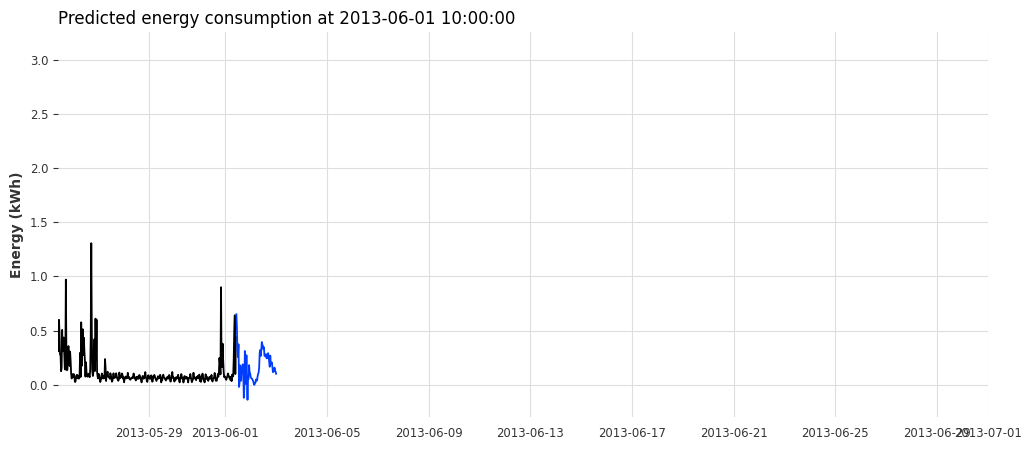

In [22]:
plt.ioff()
fig, ax = plt.subplots(figsize=(12, 5))

cutoff_dates = crossval_df.cutoff_date.unique()


def animate_forecast(t):
    plt.cla()

    cutoff_date = cutoff_dates[t]
    history = multivariate_dataset.get_history(cutoff_date)
    forecast = (
        crossval_df.loc[crossval_df.cutoff_date == cutoff_date].set_index("timestamp").drop(columns=["cutoff_date"])
    )

    ax.plot(history.index, history.y)
    ax.plot(forecast.index, forecast.yhat)
    ax.set_xlim(cutoff_dates[0] - pd.Timedelta('7D'), crossval_df.timestamp.max())
    ax.set_ylabel("Energy (kWh)")
    ax.set_title(f"Predicted energy consumption at {cutoff_date}", fontsize="large", loc="left")


ani = animation.FuncAnimation(fig, animate_forecast, frames=len(cutoff_dates))
ani

In [28]:
plt.ion()
plt.close()

# Metrics

In [29]:
from enfobench.evaluation import evaluate_metrics
from enfobench.evaluation.metrics import mean_absolute_error, mean_bias_error

In [30]:
overall_metrics = evaluate_metrics(crossval_df, metrics={"MAE": mean_absolute_error, "MBE": mean_bias_error})
overall_metrics

,MAE,MBE,weight
0,0.107322,0.005982,1.0


In [31]:
metrics_per_cutoff = evaluate_metrics(
    crossval_df,
    metrics={"MAE": mean_absolute_error, "MBE": mean_bias_error},
    groupby="cutoff_date",
)
metrics_per_cutoff.head()

100%|██████████| 29/29 [00:00<00:00, 450.61it/s]


,cutoff_date,MAE,MBE,weight
0,2013-06-01 10:00:00,0.135932,0.004241,1.0
1,2013-06-02 10:00:00,0.098771,0.045234,1.0
2,2013-06-03 10:00:00,0.097035,-0.005442,1.0
3,2013-06-04 10:00:00,0.099615,-0.008850,1.0
4,2013-06-05 10:00:00,0.095925,-0.016313,1.0


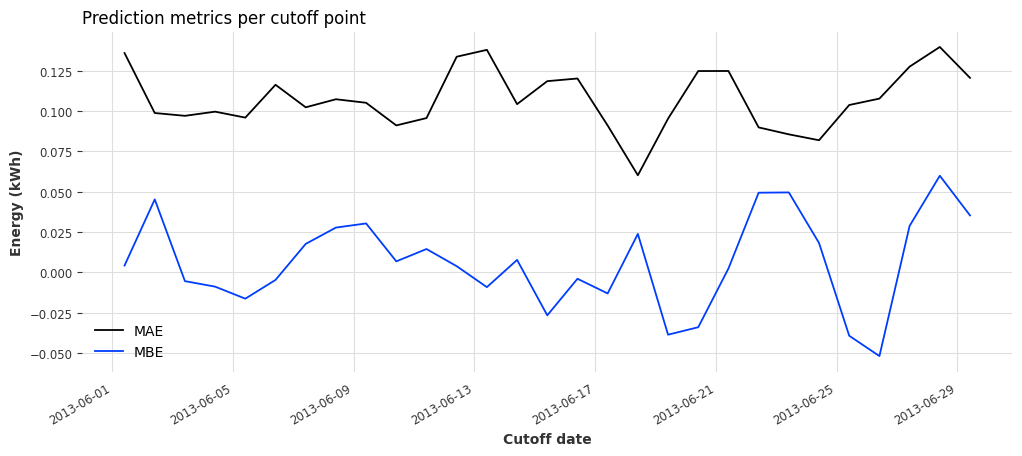

In [32]:
fig, ax = plt.subplots(figsize=(12, 5))
metrics_per_cutoff.set_index("cutoff_date")[["MAE", "MBE"]].plot(ax=ax)
ax.set_xlabel("Cutoff date")
ax.set_ylabel("Energy (kWh)")
ax.set_title("Prediction metrics per cutoff point", fontsize="large", loc="left")
plt.show()